In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import datetime
from sklearn.preprocessing import LabelEncoder
#한글깨짐방지
plt.rc('font',family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

from IPython.core.display import display, HTML
display(HTML('<style>.container {width:100% !important; }</style>'))

In [2]:
path = './data/'
train = pd.read_csv(path +'201901-202003.csv')
submission = pd.read_csv(path + 'submission.csv')

In [3]:
# 시군구 결측은 모두 세종
train.loc[train.CARD_CCG_NM.isna(),'CARD_CCG_NM'] = '세종'
train.loc[train.HOM_CCG_NM.isna(),'HOM_CCG_NM'] = '세종'

### 환불과 거래금액의 관계
* 일반적으로 환불을 많이하는 물품은 다소 문제가 있다고 생각...?

In [10]:
train.head()

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT
0,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,20s,1,1,4,311200,4
1,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,1,2,7,1374500,8
2,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,2,2,6,818700,6
3,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,3,4,1717000,5
4,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,4,3,1047300,3


#### 이용건수(CNT)와 이용고객수(CSTMR_CNT)
* 양수면 CNT가 큼 : 여러번구매한 고객의 수
* 음수면 CNT가 작음 : 환불한 고객의 수

In [22]:
train['differ'] = (train.CNT- train.CSTMR_CNT)

In [27]:
# 양수일때 최대 80000만??????
train.loc[train['differ'] >0,'differ'].describe()

count    1.912295e+07
mean     8.276689e+01
std      7.365802e+02
min      1.000000e+00
25%      2.000000e+00
50%      6.000000e+00
75%      2.200000e+01
max      8.807800e+04
Name: differ, dtype: float64

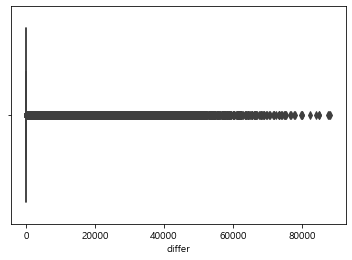

In [31]:
sns.boxplot(train.loc[train['differ'] >0,'differ'])

In [28]:
# 음수일떄 최대 236??????
train.loc[train['differ'] <0,'differ'].describe()

count    85036.000000
mean        -2.367738
std          4.255592
min       -236.000000
25%         -2.000000
50%         -1.000000
75%         -1.000000
max         -1.000000
Name: differ, dtype: float64

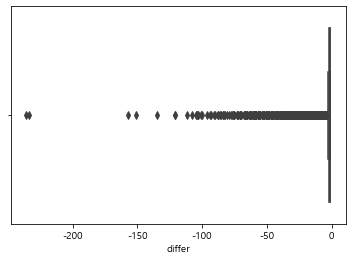

In [30]:
sns.boxplot(train.loc[train['differ'] <0,'differ'])

In [35]:
#최대인 경우 편의점 - 동네주민이 자주 이용한다고 가정한다면 충분히 일리있다.
train.loc[train['differ'].idxmax()]

REG_YYMM           201907
CARD_SIDO_NM           경기
CARD_CCG_NM           화성시
STD_CLSS_NM       체인화 편의점
HOM_SIDO_NM            경기
HOM_CCG_NM            화성시
AGE                   30s
SEX_CTGO_CD             1
FLC                     2
CSTMR_CNT           32205
AMT             922668550
CNT                120283
differ              88078
Name: 10462069, dtype: object

In [36]:
# 항공의 경우 취소가 잦다. 특히 2월의 경우 코로나가 시작되기 시작했으므로 취소하는 것도 이해가 된다. 강서구에 위치한 김포공항으로 이동하려는 제주도민의 이동이 감소
train.loc[train['differ'].idxmin()]

REG_YYMM           202002
CARD_SIDO_NM           서울
CARD_CCG_NM           강서구
STD_CLSS_NM     정기 항공 운송업
HOM_SIDO_NM            제주
HOM_CCG_NM            제주시
AGE                   40s
SEX_CTGO_CD             2
FLC                     3
CSTMR_CNT             643
AMT               9643960
CNT                   407
differ               -236
Name: 22840723, dtype: object

#### 좀더 상세히 살펴보자

In [39]:
plus_custom = train[train['differ']>0]

In [54]:
#지역별 업종으로 묶어본다
sample = plus_custom.groupby(['CARD_SIDO_NM','STD_CLSS_NM'])['differ'].sum().reset_index()

#코로나에 영향받지 않는업종들이 주로 보인다. 
sample.sort_values('differ',ascending=False).head(30)

,CARD_SIDO_NM,STD_CLSS_NM,differ
337,서울,체인화 편의점,147113656
338,서울,택시 운송업,139536124
72,경기,체인화 편의점,133933452
59,경기,슈퍼마켓,65963093
323,서울,슈퍼마켓,57973625
340,서울,한식 음식점업,44585525
75,경기,한식 음식점업,42670367
47,경기,기타 대형 종합 소매업,40269395
297,부산,체인화 편의점,37190940
314,서울,기타음식료품위주종합소매업,33478566


#### pivoting으로 재확인

In [58]:
pivot_plus = plus_custom.pivot_table(index = ['CARD_SIDO_NM','STD_CLSS_NM'],columns = 'REG_YYMM', values= 'differ', aggfunc ='sum').reset_index()

In [60]:
# 코로나로 인해 유지되는 업종, 유지되지 않는 업종이 눈에 드러남
pivot_plus[pivot_plus.CARD_SIDO_NM =='서울']

REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,201901,201902,201903,201904,201905,201906,201907,201908,201909,201910,201911,201912,202001,202002,202003
304,서울,건강보조식품 소매업,3912.0,3074.0,3035.0,3225.0,3294.0,3201.0,3565.0,3049.0,3044.0,3202.0,2931.0,2829.0,2901.0,2430.0,2862.0
305,서울,골프장 운영업,367.0,1112.0,2019.0,2025.0,2049.0,1879.0,1798.0,1592.0,1488.0,1700.0,1240.0,991.0,877.0,918.0,1486.0
306,서울,과실 및 채소 소매업,120094.0,94458.0,128841.0,127836.0,127737.0,125042.0,115402.0,112316.0,112555.0,122181.0,120869.0,118273.0,136889.0,133678.0,196619.0
307,서울,관광 민예품 및 선물용품 소매업,2008.0,1604.0,3100.0,3082.0,3388.0,3042.0,2202.0,3279.0,1891.0,1988.0,3562.0,2944.0,1612.0,773.0,405.0
308,서울,그외 기타 스포츠시설 운영업,994.0,925.0,686.0,507.0,592.0,716.0,663.0,1159.0,518.0,587.0,461.0,772.0,1385.0,347.0,125.0
309,서울,그외 기타 종합 소매업,214496.0,172696.0,234410.0,220397.0,242192.0,221711.0,204006.0,203637.0,217706.0,241937.0,241065.0,254589.0,212733.0,195209.0,234911.0
310,서울,기타 대형 종합 소매업,2039160.0,1679364.0,2124836.0,2108885.0,2289758.0,2079633.0,2303042.0,2185707.0,1943141.0,2114800.0,1938381.0,1960508.0,1853438.0,1624728.0,1799224.0
311,서울,기타 수상오락 서비스업,117.0,70.0,74.0,55.0,98.0,66.0,55.0,41.0,60.0,70.0,31.0,51.0,41.0,21.0,40.0
312,서울,기타 외국식 음식점업,119462.0,85791.0,121474.0,116474.0,112711.0,107588.0,113139.0,112414.0,104009.0,133726.0,130583.0,126219.0,108695.0,98312.0,90200.0
313,서울,기타 주점업,6611.0,5618.0,6924.0,6675.0,7197.0,6711.0,7208.0,7110.0,6847.0,6890.0,6526.0,7609.0,6238.0,5493.0,4973.0


#### 환불쪽을 확인해보자

In [64]:
minus_custom = train[train.differ<0]

In [66]:
#지역별 업종으로 묶어본다
sample = minus_custom.groupby(['CARD_SIDO_NM','STD_CLSS_NM'])['differ'].sum().reset_index()

#항공, 여행 등은 환불이 잘일어난다
sample.sort_values('differ',ascending=True).head(30)

,CARD_SIDO_NM,STD_CLSS_NM,differ
280,서울,정기 항공 운송업,-66849
459,제주,정기 항공 운송업,-26453
242,부산,정기 항공 운송업,-23833
425,전북,정기 항공 운송업,-19360
273,서울,여행사업,-9357
271,서울,스포츠 및 레크레이션 용품 임대업,-6216
262,서울,내항 여객 운송업,-4241
362,인천,정기 항공 운송업,-2946
289,서울,화장품 및 방향제 소매업,-2019
257,서울,그외 기타 종합 소매업,-1757


In [67]:
pivot_minus = minus_custom.pivot_table(index = ['CARD_SIDO_NM','STD_CLSS_NM'],columns = 'REG_YYMM', values= 'differ', aggfunc ='sum').reset_index()

In [68]:
# 코로나로 인해 유지되는 업종, 유지되지 않는 업종이 눈에 드러남
pivot_minus[pivot_minus.CARD_SIDO_NM =='서울']

REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,201901,201902,201903,201904,201905,201906,201907,201908,201909,201910,201911,201912,202001,202002,202003
253,서울,건강보조식품 소매업,-41.0,-21.0,-15.0,-14.0,-21.0,-14.0,-13.0,-13.0,-20.0,-9.0,-5.0,-6.0,-24.0,-20.0,-14.0
254,서울,과실 및 채소 소매업,-1.0,-2.0,-1.0,-3.0,NaN,-2.0,-3.0,-1.0,-2.0,NaN,-1.0,-2.0,NaN,-2.0,NaN
255,서울,관광 민예품 및 선물용품 소매업,-3.0,-1.0,-7.0,-6.0,-2.0,-6.0,-3.0,-2.0,-2.0,-4.0,-1.0,-2.0,-1.0,-1.0,-1.0
256,서울,그외 기타 스포츠시설 운영업,NaN,-1.0,NaN,NaN,NaN,-1.0,NaN,-3.0,NaN,NaN,NaN,NaN,-2.0,NaN,NaN
257,서울,그외 기타 종합 소매업,-114.0,-101.0,-113.0,-115.0,-114.0,-92.0,-119.0,-107.0,-113.0,-155.0,-170.0,-83.0,-86.0,-200.0,-75.0
258,서울,기타 대형 종합 소매업,-37.0,-39.0,-60.0,-46.0,-33.0,-47.0,-31.0,-21.0,-46.0,-24.0,-46.0,-37.0,-30.0,-42.0,-22.0
259,서울,기타 외국식 음식점업,-58.0,-52.0,-51.0,-48.0,-41.0,-45.0,-41.0,-83.0,-62.0,-72.0,-78.0,-93.0,-85.0,-52.0,-44.0
260,서울,기타 주점업,-3.0,-1.0,-1.0,-2.0,-4.0,-3.0,-6.0,-1.0,-1.0,-2.0,-3.0,-2.0,-3.0,-2.0,-2.0
261,서울,기타음식료품위주종합소매업,NaN,NaN,NaN,-6.0,-2.0,NaN,-2.0,NaN,-3.0,NaN,-3.0,-2.0,NaN,NaN,-1.0
262,서울,내항 여객 운송업,-200.0,-352.0,-183.0,-370.0,-300.0,-287.0,-273.0,-394.0,-627.0,-397.0,-231.0,-197.0,-171.0,-186.0,-73.0


#### 음양을 구분없이 해도 될까?

In [69]:
pivot_train = train.pivot_table(index = ['CARD_SIDO_NM','STD_CLSS_NM'],columns = 'REG_YYMM', values= 'differ', aggfunc ='sum').reset_index()

In [72]:
# 특징이 사라진다. 따라서 나눠서 하는 것이 맞다 
pivot_train[pivot_train.CARD_SIDO_NM =='서울']

REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,201901,201902,201903,201904,201905,201906,201907,201908,201909,201910,201911,201912,202001,202002,202003
305,서울,건강보조식품 소매업,3871.0,3053.0,3020.0,3211.0,3273.0,3187.0,3552.0,3036.0,3024.0,3193.0,2926.0,2823.0,2877.0,2410.0,2848.0
306,서울,골프장 운영업,367.0,1112.0,2019.0,2025.0,2049.0,1879.0,1798.0,1592.0,1488.0,1700.0,1240.0,991.0,877.0,918.0,1486.0
307,서울,과실 및 채소 소매업,120093.0,94456.0,128840.0,127833.0,127737.0,125040.0,115399.0,112315.0,112553.0,122181.0,120868.0,118271.0,136889.0,133676.0,196619.0
308,서울,관광 민예품 및 선물용품 소매업,2005.0,1603.0,3093.0,3076.0,3386.0,3036.0,2199.0,3277.0,1889.0,1984.0,3561.0,2942.0,1611.0,772.0,404.0
309,서울,그외 기타 스포츠시설 운영업,994.0,924.0,686.0,507.0,592.0,715.0,663.0,1156.0,518.0,587.0,461.0,772.0,1383.0,347.0,125.0
310,서울,그외 기타 종합 소매업,214382.0,172595.0,234297.0,220282.0,242078.0,221619.0,203887.0,203530.0,217593.0,241782.0,240895.0,254506.0,212647.0,195009.0,234836.0
311,서울,기타 대형 종합 소매업,2039123.0,1679325.0,2124776.0,2108839.0,2289725.0,2079586.0,2303011.0,2185686.0,1943095.0,2114776.0,1938335.0,1960471.0,1853408.0,1624686.0,1799202.0
312,서울,기타 수상오락 서비스업,117.0,70.0,74.0,55.0,98.0,66.0,55.0,41.0,60.0,70.0,31.0,51.0,41.0,21.0,40.0
313,서울,기타 외국식 음식점업,119404.0,85739.0,121423.0,116426.0,112670.0,107543.0,113098.0,112331.0,103947.0,133654.0,130505.0,126126.0,108610.0,98260.0,90156.0
314,서울,기타 주점업,6608.0,5617.0,6923.0,6673.0,7193.0,6708.0,7202.0,7109.0,6846.0,6888.0,6523.0,7607.0,6235.0,5491.0,4971.0


#### 함수화
* 다른변수와 동일하게 19년도 반영

In [106]:
def cust_differ(data):
    data['differ'] = (data.CNT- data.CSTMR_CNT)
    
    #양수(단골)
    plus_custom = data[data['differ']>0]
    pivot_plus = plus_custom.pivot_table(index = ['CARD_SIDO_NM','STD_CLSS_NM'],columns = 'REG_YYMM', values= 'differ', aggfunc ='sum').reset_index()
    
    melt_plus = pivot_plus.melt(id_vars=['CARD_SIDO_NM','STD_CLSS_NM'],value_name='loyal')
    melt_plus['year'] = melt_plus['REG_YYMM'].apply(lambda x: int(str(x)[:4]))
    melt_plus['month'] = melt_plus['REG_YYMM'].apply(lambda x: int(str(x)[5:]))
    
    #2019만 사용
    melt_plus = melt_plus[melt_plus.year == 2019]
    melt_plus.drop(['REG_YYMM','year'],axis= 1,inplace = True)
    

    
    #음수(환불)
    minus_custom = data[data['differ']<0]
    pivot_minus = minus_custom.pivot_table(index = ['CARD_SIDO_NM','STD_CLSS_NM'],columns = 'REG_YYMM', values= 'differ', aggfunc ='sum').reset_index()
    
    melt_minus = pivot_minus.melt(id_vars=['CARD_SIDO_NM','STD_CLSS_NM'],value_name='refund')
    melt_minus['year'] = melt_minus['REG_YYMM'].apply(lambda x: int(str(x)[:4]))
    melt_minus['month'] = melt_minus['REG_YYMM'].apply(lambda x: int(str(x)[5:]))
    #2019만 사용
    melt_minus = melt_minus[melt_minus.year == 2019]
    melt_minus.drop(['REG_YYMM','year'],axis= 1,inplace = True)
    

    
    #둘 결헙
    cust_differ_df = pd.merge(melt_plus,melt_minus,how= 'outer')
    
    return cust_differ_df

In [108]:
cust_differ(train)

,CARD_SIDO_NM,STD_CLSS_NM,loyal,month,refund
0,강원,건강보조식품 소매업,80.0,1,-32.0
1,강원,건강보조식품 소매업,80.0,1,-14.0
2,강원,건강보조식품 소매업,84.0,1,-32.0
3,강원,건강보조식품 소매업,84.0,1,-14.0
4,강원,골프장 운영업,14890.0,1,NaN
...,...,...,...,...,...
9843,대전,여행사업,NaN,6,NaN
9844,대전,여행사업,NaN,7,NaN
9845,대전,여행사업,NaN,8,NaN
9846,대전,여행사업,NaN,9,NaN


### FLC는 의미가 있을까?
* 예측 템플릿만들떄 10대와 노년부부층이랑 연계됨 이는 없는 조합
* 결론 FLC자체는 의미가 있는 것이 맞다  
※ 단 
      10대 1  
      20대 1,2 
      30대 1,2,3  
      40대 2,3,4  
      50대 2,3,4  
      60대 5  
      70대 5  
      로 고정해야함

In [118]:
#flc의 분포에 대한 탐구
flc_check = train.pivot_table(index= ['AGE','SEX_CTGO_CD'], columns= 'FLC',values='AMT',aggfunc='count')

In [119]:
#데이터 상에서는 10대지만 결혼한사람이 없고, 20대지만 중고생자녀가 있는 그런 특이 케이스는 고려하지 않음 
#40대 이상에는 1인가구가 없음

flc_check

FLC                      1          2          3          4          5
AGE SEX_CTGO_CD                                                       
10s 1             151878.0        NaN        NaN        NaN        NaN
    2             162796.0        NaN        NaN        NaN        NaN
20s 1            2398936.0   392141.0        NaN        NaN        NaN
    2            1836208.0   464390.0        NaN        NaN        NaN
30s 1             609360.0  2482016.0   182020.0        NaN        NaN
    2             366962.0  1772415.0   137746.0        NaN        NaN
40s 1                  NaN   687608.0  2120893.0   717934.0        NaN
    2                  NaN   386640.0  1422700.0   466672.0        NaN
50s 1                  NaN     2191.0   133842.0  2538890.0        NaN
    2                  NaN     1400.0    57540.0  1721824.0        NaN
60s 1                  NaN        NaN        NaN        NaN  1575454.0
    2                  NaN        NaN        NaN        NaN  1030714.0
70s 1                  NaN        NaN        NaN        NaN   513215.0
    2                  NaN        NaN        NaN        NaN   363407.0

In [122]:
#flc의 분포에 대한 탐구
flc_amt = train.pivot_table(index= ['AGE','SEX_CTGO_CD'], columns= 'FLC',values='AMT',aggfunc='mean')

In [123]:
#flc에 따른 차이는 분명 있음
flc_amt

FLC                         1             2             3             4  \
AGE SEX_CTGO_CD                                                           
10s 1            5.275177e+05           NaN           NaN           NaN   
    2            4.702632e+05           NaN           NaN           NaN   
20s 1            1.498103e+06  8.264240e+05           NaN           NaN   
    2            1.453384e+06  8.481769e+05           NaN           NaN   
30s 1            1.049299e+06  2.496394e+06  8.923656e+05           NaN   
    2            8.525706e+05  2.309480e+06  8.364154e+05           NaN   
40s 1                     NaN  1.566269e+06  3.095814e+06  1.980691e+06   
    2                     NaN  1.376943e+06  3.130178e+06  1.851080e+06   
50s 1                     NaN  6.538575e+05  1.280460e+06  3.750812e+06   
    2                     NaN  6.119955e+05  1.223301e+06  3.517175e+06   
60s 1                     NaN           NaN           NaN           NaN   
    2                     NaN           NaN           NaN           NaN   
70s 1                     NaN           NaN           NaN           NaN   
    2                     NaN           NaN           NaN           NaN   

FLC                         5  
AGE SEX_CTGO_CD                
10s 1                     NaN  
    2                     NaN  
20s 1                     NaN  
    2                     NaN  
30s 1                     NaN  
    2                     NaN  
40s 1                     NaN  
    2                     NaN  
50s 1                     NaN  
    2                     NaN  
60s 1            3.467947e+06  
    2            3.203054e+06  
70s 1            2.598175e+06  
    2            2.211589e+06